<a href="https://colab.research.google.com/github/ariadna-guzman/E3-Deteccion-de-plagio-TC3002B.301/blob/main/Evidencia_2_Modelo_Mejorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidencia 2: Modelo Mejorado

- Ariadna Jocelyn Guzmán Jiménez A01749373
- Jorge Chávez Badillo A01749448
- Amy Murakami Tsutsumi A01750185


## Instalación de Librerías

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00


In [ ]:
!pip -q install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00


In [ ]:
!pip -q install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importación de Librerías

In [ ]:
import torch
# Para el cálculo de la distancia entre párrafos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Para la manipulación y lectura de archivos
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
# Para la visualización, análisis y manipulación de los datos 
import pandas as pd
from tqdm import tqdm 
# Para la creación de vectores y matrices
import numpy as np
from keras_preprocessing.sequence import pad_sequences
# Implementación de BERT
from transformers import BertTokenizer, AutoModelForSequenceClassification
# Para la traducción de textos
from transformers import MarianMTModel, MarianTokenizer
from langdetect import detect, DetectorFactory

## Importación de Textos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
genuinos = '/content/drive/Shareddrives/Desarrollo de Aplicaciones Avanzadas de Ciencias Computacionales/Reto/Evidencia 2/2023-Datasets/Etapa1/documentos-genuinos/'
sospechosos = '/content/drive/Shareddrives/Desarrollo de Aplicaciones Avanzadas de Ciencias Computacionales/Reto/Evidencia 2/2023-Datasets/Etapa1/docmentos-sospechosos/'

### Creación de Data Frame

In [ ]:
def create_frame(path):
  '''
  Función que crea el dataframe que contiene el nombre del archivo 
  y contenido para la carpeta de archivos (path) seleccionada.
  '''
  content = []
  names = []
  files_list = sorted(os.listdir(path))
  for file_name in files_list:
    with open(path + file_name, 'r') as file:
      data = file.read().rstrip()
      content.append(data)
      names.append(file_name)
  dictionary = {'name': names, 'content': content}
  df = pd.DataFrame(dictionary)
  return df

Mostrar los primeros cinco documentos de la carpeta de documentos genuinos.

In [ ]:
df_genuinos = create_frame(genuinos)
df_genuinos.head(5)

,name,content
0,org-300.txt,Automatic software plagiarism detection tools ...
1,org-301.txt,A casual comment by a student alerted the auth...
2,org-302.txt,Paraphrase types have been proposed by researc...
3,org-303.txt,This paper addresses the issue of text matchin...
4,org-304.txt,This work presents a Sentence Hashing Algorith...


## Implementación de Bert
***(Bidirectional Encoder Representations From Transformers)***

In [ ]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case = True)

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           output_attentions = False,
                                                           output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

### Vectorización

#### Por texto

In [ ]:
def vectorize_text(tokenizer, model, abstract, MAX_LEN = 510):
  '''
  Función que genera la representación vectorial de un documento.
  Recibe como parámetros el tokenizer, el modelo, el documento y 
  el número máximo de tokens. 
  '''
  inputs = tokenizer.encode(abstract, 
                            add_special_tokens = True, 
                            max_length = MAX_LEN,)    

  results = pad_sequences([inputs], 
                          maxlen=MAX_LEN, 
                          dtype="long", 
                          truncating="post", 
                          padding="post")
  inputs = results[0] # Eliminar lista exterior

  # Máscaras
  ''' for i in inputs:
    mask = int(i>0)'''
  mask = [int(i > 0) for i in inputs]

  # Tensores
  inputs = torch.tensor(inputs)
  mask = torch.tensor(mask)

  # Dimensión adicional para batch
  inputs = inputs.unsqueeze(0)
  mask = mask.unsqueeze(0)

  # Evaluación de modelo
  model.eval()

  # Recopílación de estado a través de BERT
  with torch.no_grad():        
        logits, encoded_layers = model(input_ids = inputs, 
                                        token_type_ids = None, 
                                        attention_mask = mask,
                                        return_dict = False)

  layer_i = 12 # Última capa BERT antes de clasificación
  batch_i = 0 # Entrada del batch
  token_i = 0 # Primer token

  # Extraer el vector
  vector = encoded_layers[layer_i][batch_i][token_i]

  # Numpy array
  vector = vector.detach().cpu().numpy()

  return vector

#### Base de Datos

In [ ]:
def vectorize_database(data):
  '''
  Función que genera una base de datos que contiene los vectores
  de todos los documentos. 
  '''
  vectors = []

  # Obtención de datos generales del contenido
  source = data.content.values

  # Recorrer texto para la obtención de los embeddings
  for content in tqdm(source):
    # Obtener el embedding
    vector = vectorize_text(tokenizer, model, content)
    vectors.append(vector)
  
  data['vectors'] = vectors
  data['vectors'] = data['vectors'].apply(lambda emb: np.array(emb))
  data['vectors'] = data['vectors'].apply(lambda emb: emb.reshape(1, -1))
  return data

### Creación de Vector para los Archivos Genuinos

In [ ]:
vector_genuinos = vectorize_database(df_genuinos)

100%|██████████| 120/120 [04:48<00:00,  2.40s/it]


In [ ]:
vector_genuinos.head()

,name,content,vectors
0,org-300.txt,Automatic software plagiarism detection tools ...,"[[-0.64271873, -0.26977772, -0.763381, -0.0089..."
1,org-301.txt,A casual comment by a student alerted the auth...,"[[-0.51203465, -0.3626315, -0.53556347, 0.1047..."
2,org-302.txt,Paraphrase types have been proposed by researc...,"[[-0.5537736, -0.32080397, -0.92781377, -0.348..."
3,org-303.txt,This paper addresses the issue of text matchin...,"[[-1.0950634, -0.34306043, -0.30031648, 0.2014..."
4,org-304.txt,This work presents a Sentence Hashing Algorith...,"[[-0.9064658, -0.37186188, -0.015655695, -0.31..."


## Funciones para la Detección de Plagio

In [ ]:
def vectorize_cosine(sus_text):
  '''
  Función que crea un vector de acuerdo al texto de entrada 
  para ajustarlo para calcular la similitud de coseno.
  '''
  
  sus_vect = vectorize_text(tokenizer, model, sus_text)
  sus_vect = np.array(sus_vect)
  sus_vect = sus_vect.reshape(1, -1)
  return sus_vect

In [ ]:
def detect_plagiarism(score, threshold):
  '''
  Función que determina si el texto es plagio o no de acuerdo 
  a un cierto umbral.
  '''

  status = False

  if(score >= threshold):
    status = True
  
  return status 

In [ ]:
def plagiarism_analysis(sus_name, sus_text, database_vector, threshold):
  '''
  Función que regresa los resultados de la detección de plagio, señalando
  los archivos comparados y el nivel de similitud obtenido.
  '''

  sus_vect = vectorize_cosine(sus_text)

  # Similitud Coseno
  database_vector['similarity'] = database_vector['vectors'].apply(
      lambda x: cosine_similarity(sus_vect, x))
  database_vector['similarity'] = database_vector['similarity'].apply(
      lambda x: x[0][0])
  
 # Top 5 Archivos similares  
  similar_files = database_vector.sort_values(by = 'similarity', 
                                              ascending = False)[0:4]
  df_result = similar_files[['name', 
                             'content', 
                             'similarity']].reset_index(drop = True)
  
  similarity_score = df_result.iloc[0]['similarity']
  most_similar_f_name = df_result.iloc[0]['name']
  most_similar_f_content = df_result.iloc[0]['content']
  status = detect_plagiarism(similarity_score, threshold)


  plagiarism_analysis = ('Nombre del archivo sospechoso: '
                         + sus_name
                         + '\nNombre del archivo genuino: '
                         + most_similar_f_name
                         + '\nStatus: ' 
                         + str(status) 
                         + '\nSimilitud: ' 
                         + str(similarity_score) 
                         + '\nContenido del archivo genuino: \n'
                         + most_similar_f_content
                         + '\nContenido del archivo sospechoso: \n' 
                         + sus_text
                         )
  return plagiarism_analysis

## Detección de Plagio

In [ ]:
df_sus = create_frame(sospechosos)
df_sus.head()

,name,content
0,FID-01.txt,This systematic review provides unique finding...
1,FID-02.txt,"In this review, we describe the application of..."
2,FID-03.txt,How to measure similarity between two sequence...
3,FID-04.txt,Text similarity measurement is the basis of na...
4,FID-05.txt,Hoy en día el idioma ha dejado de ser una barr...


In [ ]:
df_sus.iloc[3]

name                                              FID-04.txt
content    Text similarity measurement is the basis of na...
Name: 3, dtype: object

In [ ]:
pred_values = []

def sus_analysis(path_sus):
  '''
  Función que compara todos los archivos genuinos con todos los archivos 
  sospechosos. Muestra el archivo sospechoso, el estado, la similitud y 
  el archivo que tiene mayor similitud.
  '''
  content = []
  names = []
  files_list = sorted(os.listdir(path_sus))
  for file_name in files_list:
    with open(path_sus + file_name, 'r') as file:
      data = file.read().rstrip()
      content.append(data)
      names.append(file_name)
  for id in range(len(names)):
    analysis = plagiarism_analysis(names[id], content[id], vector_genuinos, 0.92)
    print("="*30)
    print(analysis)
    if ("\nStatus: True" in analysis):
      pred_values.append(1)
    else: 
      pred_values.append(0)
  return 

In [ ]:
sus_analysis(sospechosos)

Nombre del archivo sospechoso: FID-01.txt
Nombre del archivo genuino: org-325.txt
Status: True
Similitud: 0.993181
Contenido del archivo genuino: 
This systematic review provides unique findings with an up-to-date examination of artificial intelligence (AI) in higher education (HE) from 2016 to 2022. Using PRISMA principles and protocol, 138 articles were identified for a full examination. Using a priori, and grounded coding, the data from the 138 articles were extracted, analyzed, and coded. The findings of this study show that in 2021 and 2022, publications rose nearly two to three times the number of previous years. With this rapid rise in the number of AIEd HE publications, new trends have emerged. The findings show that research was conducted in six of the seven continents of the world. The trend has shifted from the US to China leading in the number of publications. Another new trend is in the researcher affiliation as prior studies showed a lack of researchers from departments o

## Métricas del Modelo

In [56]:
name_sos = sorted(os.listdir(sospechosos))
true_labels = []

for i in name_sos:
  if int(i[4:6]) % 2 == 0:
    true_labels.append(1)
  else:
    true_labels.append(0)
print("Predictions:\n",pred_values)
print("True:\n",true_labels)

print('\nAccuracy Score: {:.4f}'.format(accuracy_score(true_labels, pred_values)))
cf_mat = confusion_matrix(true_labels, pred_values)
print('Confusion Matrix')
print(cf_mat)

Predictions:
 [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]
True:
 [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Accuracy Score: 0.2000
Confusion Matrix
[[2 6]
 [6 1]]


In [57]:
def metricas(cf_mat):
  '''
  Función para obtener las métricas del modelo a partir de
  la matriz de confusión
  '''
  precision = cf_mat[0][0] / (cf_mat[0][0] + cf_mat[0][1])
  recall = cf_mat[0][0] / (cf_mat[0][0] + cf_mat[1][0])
  specificity = cf_mat[1][1] / (cf_mat[1][1] + cf_mat[0][1])
  print('Precision: {:.4f}'.format(precision))
  print('Recall: {:.4f}'.format(recall))
  print('Specificity: {:.4f}'.format(specificity))

In [58]:
metricas(cf_mat)

Precision: 0.2500
Recall: 0.2500
Specificity: 0.1429


## AUC-ROC Curve

In [59]:
def plot_roc_curve(true_y, y_prob):
    '''
    Función para gráficar la AUC-ROC
    '''
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

AUC score: 0.1964


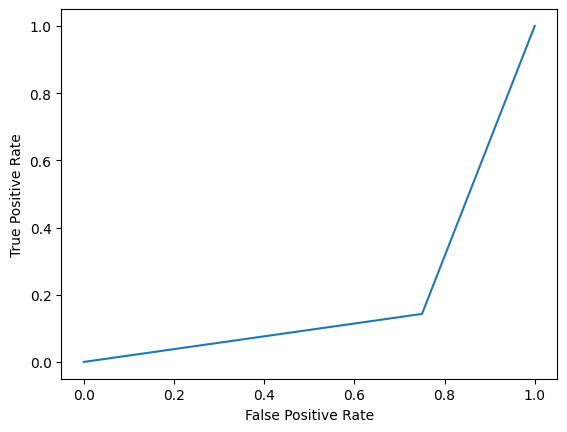

In [60]:
plot_roc_curve(true_labels, pred_values)
print('AUC score: {:.4f}'.format(roc_auc_score(true_labels, pred_values)))

## Conclusiones